In [497]:
import math
import time
from scipy.stats import norm
import numpy as np
from datetime import date,datetime,timedelta, timezone
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)

# TBC 

![TBC Template for stPERP](./stPERP/curve.png)

Brief description of different market phases supported by this template are mentioned below -

- **Genesis Mint** : Market Participant needs to stake a minimum of 5000 stPERP ('PrM_CreationFee' variable) against which he is issued 'genesisTokensMinted' number of tokens


- **Linear Curve** : Automated liquidity against the curve is now provided by a linear exchange pricing function, y = m*x + c
    - linearCurveStartPrice - Token price at the beginning of the linear curve. Same as 'genesis price'
    - linearCurveEndPrice - Token price at the end of the linear curve. 
    - linearTokensMinted - Number of tokens minted during the linear curve phase
    
    the parameters mentioned above are used to calculate the linear curve's exchange pricing function, and can be edited as per choice to try out different parameters
    
    
- **Exponential Curve** : After the linear curve, automated liquidity against the curve is then provided by an exponential exchange pricing function
![exponential exchange pricing function](./stPERP/exponentialFunction.png)
     - constant1 - Parameter used by the exponential function. Can be increased to increase the slope
     - constant2 - Parameter used by the exponential function. Calculated from constant1, token supply and token price at the beginning of the exponential curve 


In [498]:
# Parameters

# gensis phase
PrM_CreationFee = 5000 # 5K stPERP
genesisTokensMinted = 10000
genesisPrice = 0
if genesisTokensMinted > 0 :
    genesisPrice = PrM_CreationFee / genesisTokensMinted 

# Linear Curve Phase
linearCurveStartPrice = genesisPrice
linearCurveEndPrice = 3
linearTokensMinted = 50000 # 50K tokens minted

slope = (linearCurveEndPrice - linearCurveStartPrice)/linearTokensMinted
constant = linearCurveStartPrice - (slope*genesisTokensMinted)
linearCurve_stPERPLocked = (slope/2)*(math.pow(genesisTokensMinted + linearTokensMinted,2) - math.pow(genesisTokensMinted,2)) + constant*(linearTokensMinted)     

# Exponential Curve Phase
exponentialCurve_stPERPLocked = 500000 # 500K stPERP

total_stPERP_ToBeLocked = genesisTokensMinted + linearCurve_stPERPLocked + exponentialCurve_stPERPLocked

In [499]:
# linearCurve_stPERPLocked

In [500]:
df = pd.DataFrame([], columns = ['date', 'timestamp','stPERP: To be Locked',
                                 'Token Price (stPERP)','Delta Tokens','Total Token Supply',
                                 'stPERP : Delta Locked','stPERP : Total Locked',
                                 'Note']) 
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%Y')

unix = datetime(1970, 1, 1)
cur_  = datetime(2021, 1, 1)

deltaTime = timedelta(minutes=1)

In [501]:
df.loc[0] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),total_stPERP_ToBeLocked,
             0,0,0,0,0,'Nulll State']

In [502]:
gen_percent_of_total =  100*PrM_CreationFee/total_stPERP_ToBeLocked
print('Genesis Fee = ' + str(PrM_CreationFee) + ' stPERP, which equals = ' + str(round(gen_percent_of_total,2)) + '% of the total stPERP that will be locked in the reserve pool')

Genesis Fee = 5000 stPERP, which equals = 0.84% of the total stPERP that will be locked in the reserve pool


##### Adding 2nd row : State after Genesis Fee is Paid

In [503]:
cur_ = cur_ + deltaTime
df.loc[1] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),total_stPERP_ToBeLocked - genesisTokensMinted,
             genesisPrice,genesisTokensMinted,genesisTokensMinted,
             PrM_CreationFee,PrM_CreationFee,
             'Market Creation Transaction']

In [504]:
display(df)

,date,timestamp,stPERP: To be Locked,Token Price (stPERP),Delta Tokens,Total Token Supply,stPERP : Delta Locked,stPERP : Total Locked,Note
0,2021-01-01 00:00:00,1609459200,597500.0,0,0,0,0,0,Nulll State
1,2021-01-01 00:01:00,1609459260,587500.0,0.5,10000,10000,5000,5000,Market Creation Transaction


## Linear Curve

In [505]:
def getNormalDistributionValues(mean, deviation, numberOfPoints) :
    normalPoints_ =  np.random.normal(mean, deviation, numberOfPoints)
    return normalPoints_

In [506]:
print('Exchange pricing function for linear Curve : y = ' +  str(round(slope,7)) + ' * token Supply + ' + str(constant) )

Exchange pricing function for linear Curve : y = 5e-05 * token Supply + 0.0


In [507]:
def costOfMinting(c,slope,prevTokenSupply,newTokenSupply): 
    # integral of m*x + c
    dif = c*(newTokenSupply - prevTokenSupply) + 0.5*slope*(pow(newTokenSupply,2)-pow(prevTokenSupply,2)) 
    return dif

In [508]:
deltaSupplies = getNormalDistributionValues(700, 1000,1000)
i = 0
currentTokenPrice = df.loc[len(df.index)-1,'Token Price (stPERP)']

while currentTokenPrice < linearCurveEndPrice: 
    cur_ = cur_ + deltaTime

    if i < 1000:
        token_deltaSupply = deltaSupplies[i]
    else :
        deltaSupplies = getNormalDistributionValues(700, 1000,1000)
        i = 0
        token_deltaSupply = deltaSupplies[i]
        
    totalTokenSupply = df.loc[len(df.index)-1,'Total Token Supply'] + token_deltaSupply
    
    # functional calculation      
    tokenPrice_stPERP = slope*totalTokenSupply + constant
    mintCost_stPERP = costOfMinting(constant,slope,df.loc[len(df.index)-1,'Total Token Supply'],totalTokenSupply)    
        
    stPERPLocked = stPERPLocked + mintCost_stPERP
    
    stPERP_DeltaLocked = mintCost_stPERP 
    stPERP_TotalLocked = df.loc[len(df.index)-1,'stPERP : Total Locked'] + mintCost_stPERP
    total_stPERP_to_be_locked = df.loc[len(df.index)-1,'stPERP: To be Locked'] - mintCost_stPERP
    
    if token_deltaSupply > 0:
        note = str(token_deltaSupply) + ' tokens minted for ' + str(stPERP_DeltaLocked) + ' stPERP'
    else:
        note = str(token_deltaSupply) + ' tokens burnt for ' + str(stPERP_DeltaLocked) + ' stPERP'
    
    print('StPERP Locked = ' + str(stPERP_TotalLocked) + ' Total Token Supply = ' + str(totalTokenSupply) + ' Token Price = ' + str(tokenPrice_stPERP)  )
    df.loc[len(df.index)] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),
                             total_stPERP_to_be_locked , tokenPrice_stPERP , token_deltaSupply , totalTokenSupply,
                             mintCost_stPERP , stPERP_TotalLocked,
                             note]
    currentTokenPrice = tokenPrice_stPERP


StPERP Locked = 5241.5682127947775 Total Token Supply = 10471.997350639042 Token Price = 0.5235998675319521
StPERP Locked = 5494.275500540069 Total Token Supply = 10943.994701278083 Token Price = 0.5471997350639042
StPERP Locked = 5758.121863235873 Total Token Supply = 11415.992051917125 Token Price = 0.5707996025958563
StPERP Locked = 6033.107300882191 Total Token Supply = 11887.989402556166 Token Price = 0.5943994701278084
StPERP Locked = 6319.231813479024 Total Token Supply = 12359.986753195208 Token Price = 0.6179993376597605
StPERP Locked = 6616.49540102637 Total Token Supply = 12831.98410383425 Token Price = 0.6415992051917125
StPERP Locked = 6924.89806352423 Total Token Supply = 13303.98145447329 Token Price = 0.6651990727236645
StPERP Locked = 7244.439800972603 Total Token Supply = 13775.978805112332 Token Price = 0.6887989402556166
StPERP Locked = 7575.12061337149 Total Token Supply = 14247.976155751374 Token Price = 0.7123988077875687
StPERP Locked = 7916.940500720892 Total T

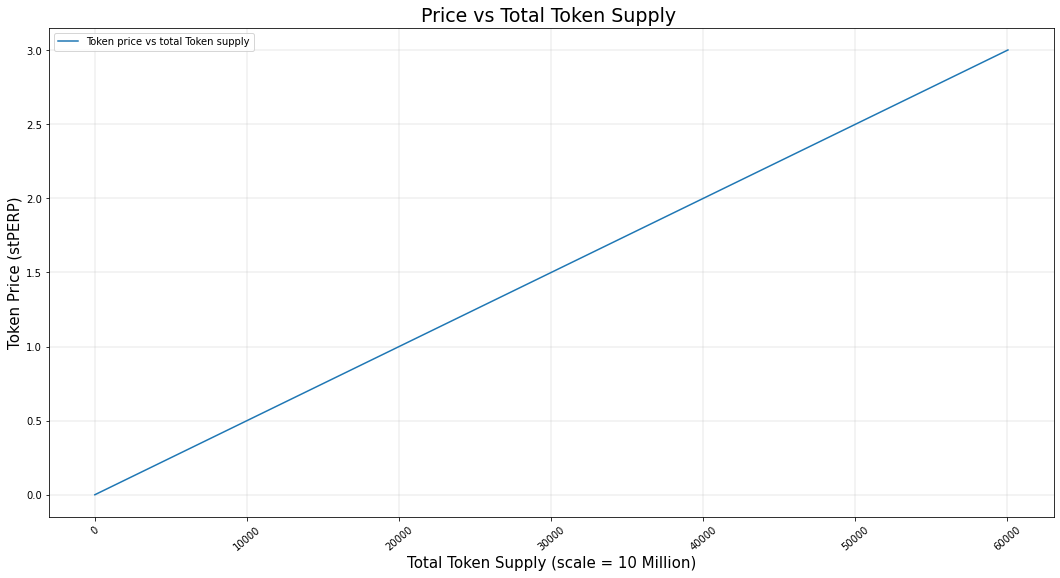

In [509]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(df.loc[:,'Total Token Supply'],df.loc[:,'Token Price (stPERP)'],label='Token price vs total Token supply')
plt.xlabel('Total Token Supply (scale = 10 Million)',fontsize = 15)
plt.ylabel('Token Price (stPERP)',fontsize = 15)
plt.title('Price vs Total Token Supply ',fontsize = 19)
plt.legend()
plt.savefig('./stPERP/Price_vs_TokenSupply.png')

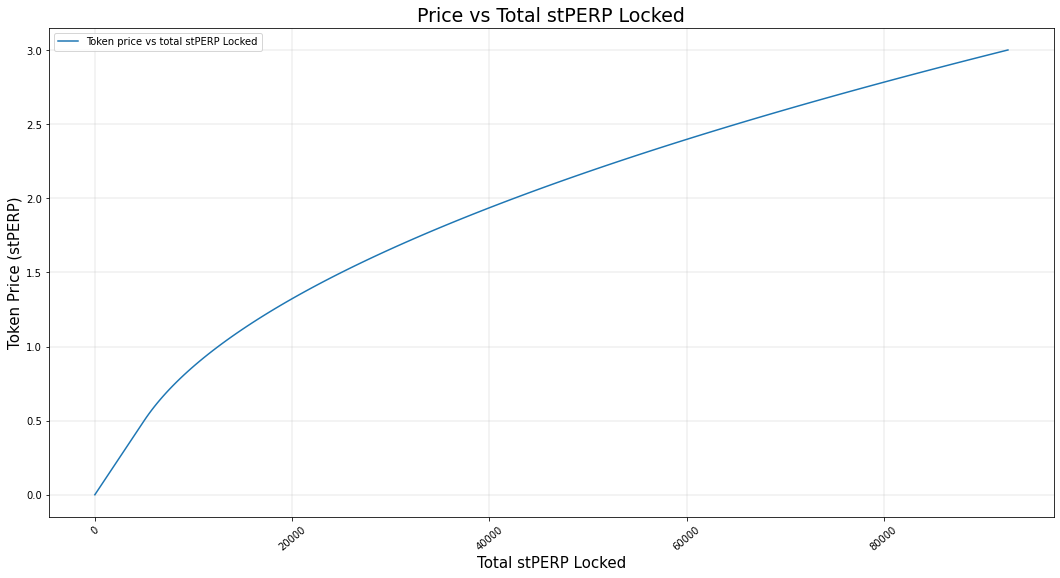

In [510]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(df.loc[:,'stPERP : Total Locked'],df.loc[:,'Token Price (stPERP)'],label='Token price vs total stPERP Locked')
plt.xlabel('Total stPERP Locked',fontsize = 15)
plt.ylabel('Token Price (stPERP)',fontsize = 15)
plt.title('Price vs Total stPERP Locked',fontsize = 19)
plt.legend()
plt.savefig('./stPERP/Price_vs_Total_stPERPLocked.png')

In [511]:
# display(df)

In [512]:
print('Total stPERP locked during the linear curve phase = ' + str(round(df.loc[len(df.index)-1,'stPERP : Total Locked'] - PrM_CreationFee,2)) + ' stPERP' )

Total stPERP locked during the linear curve phase = 87595.18 stPERP


# Exponential Curve

In [514]:
constant1 = 3000000
constant2 = math.log(df.loc[len(df.index)-1,'Token Price (stPERP)']) / (df.loc[len(df.index)-1,'Total Token Supply']*math.log(constant1))

print('The exponential curve is : y = ' + str(round(constant1,4)) + '**' + '(' + str(round(constant2,9)) + '*x)'  )


The exponential curve is : y = 3000000**(1.228e-06*x)


In [515]:
def getPriceExponentialFunction(currentTokenSupply):
    price = math.pow(constant1,constant2*currentTokenSupply)
    return price

In [516]:
def costOfMintingWithExponentialFunction(prevTokenSupply,newTokenSupply): 
    # integral of m*x + c
    t = 1/(constant2*math.log(constant1))
    dif = math.pow(constant1,constant2*newTokenSupply) - math.pow(constant1,constant2*prevTokenSupply)
    stPERPNeeded = t*dif
    return stPERPNeeded

In [517]:
currentSold = 100
deltaSupplies = getNormalDistributionValues(700, 1000,1000)
i = 0
stPERPLocked = 0

while stPERPLocked < exponentialCurve_stPERPLocked: 
    cur_ = cur_ + deltaTime

    if i < 1000:
        token_deltaSupply = deltaSupplies[i]
    else :
        deltaSupplies = getNormalDistributionValues(700, 1000,1000)
        i = 0
        token_deltaSupply = deltaSupplies[i]
        
    totalTokenSupply = df.loc[len(df.index)-1,'Total Token Supply'] + token_deltaSupply
    
    # functional calculation      
    tokenPrice_stPERP = getPriceExponentialFunction(totalTokenSupply)
    mintCost_stPERP = costOfMintingWithExponentialFunction(df.loc[len(df.index)-1,'Total Token Supply'],totalTokenSupply)    
        
    stPERPLocked = stPERPLocked + mintCost_stPERP
    
    stPERP_DeltaLocked = mintCost_stPERP 
    stPERP_TotalLocked = df.loc[len(df.index)-1,'stPERP : Total Locked'] + mintCost_stPERP
    total_stPERP_to_be_locked = df.loc[len(df.index)-1,'stPERP: To be Locked'] - mintCost_stPERP
    
    if token_deltaSupply > 0:
        note = str(token_deltaSupply) + ' tokens minted for ' + str(stPERP_DeltaLocked) + ' stPERP'
    else:
        note = str(token_deltaSupply) + ' tokens burnt for ' + str(stPERP_DeltaLocked) + ' stPERP'

    print('StPERP Locked = ' + str(stPERP_TotalLocked) + ' Total Token Supply = ' + str(totalTokenSupply) + ' Token Price = ' + str(tokenPrice_stPERP)  )

    df.loc[len(df.index)] = [pd.to_datetime(cur_,format='%d/%m/%Y'),int((cur_ - unix).total_seconds()),
                             total_stPERP_to_be_locked , tokenPrice_stPERP , token_deltaSupply , totalTokenSupply,
                             mintCost_stPERP , stPERP_TotalLocked,
                             note]


StPERP Locked = 96609.71999074292 Total Token Supply = 61353.07759706176 Token Price = 3.075089463637189
StPERP Locked = 100722.56620972231 Total Token Supply = 62674.43602638533 Token Price = 3.150392939089549
StPERP Locked = 104936.12872263476 Total Token Supply = 63995.7944557089 Token Price = 3.227540462815059
StPERP Locked = 109252.87389251056 Total Token Supply = 65317.15288503247 Token Price = 3.306577192278409
StPERP Locked = 113675.32847922706 Total Token Supply = 66638.51131435604 Token Price = 3.387549390770339
StPERP Locked = 118206.08111851988 Total Token Supply = 67959.86974367962 Token Price = 3.47050445448735
StPERP Locked = 122847.78383721305 Total Token Supply = 69281.2281730032 Token Price = 3.555490940274558
StPERP Locked = 127603.15360555385 Total Token Supply = 70602.58660232677 Token Price = 3.6425585940479124
StPERP Locked = 132474.973927562 Total Token Supply = 71923.94503165035 Token Price = 3.7317583799124296
StPERP Locked = 137466.09647032336 Total Token Sup

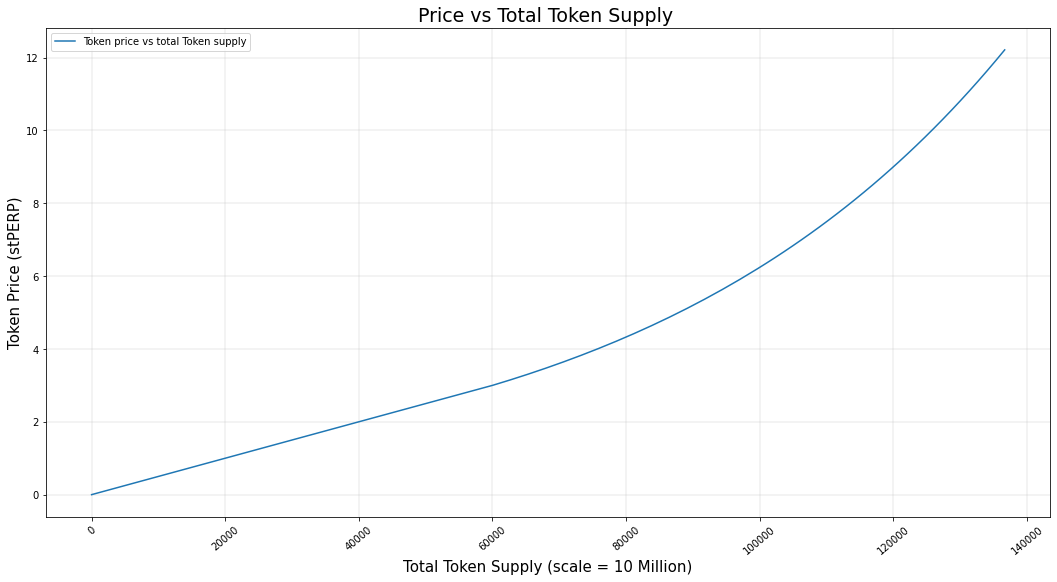

In [518]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(df.loc[:,'Total Token Supply'],df.loc[:,'Token Price (stPERP)'],label='Token price vs total Token supply')
plt.xlabel('Total Token Supply (scale = 10 Million)',fontsize = 15)
plt.ylabel('Token Price (stPERP)',fontsize = 15)
plt.title('Price vs Total Token Supply ',fontsize = 19)
plt.legend()
plt.savefig('./stPERP/Price_vs_TokenSupply.png')

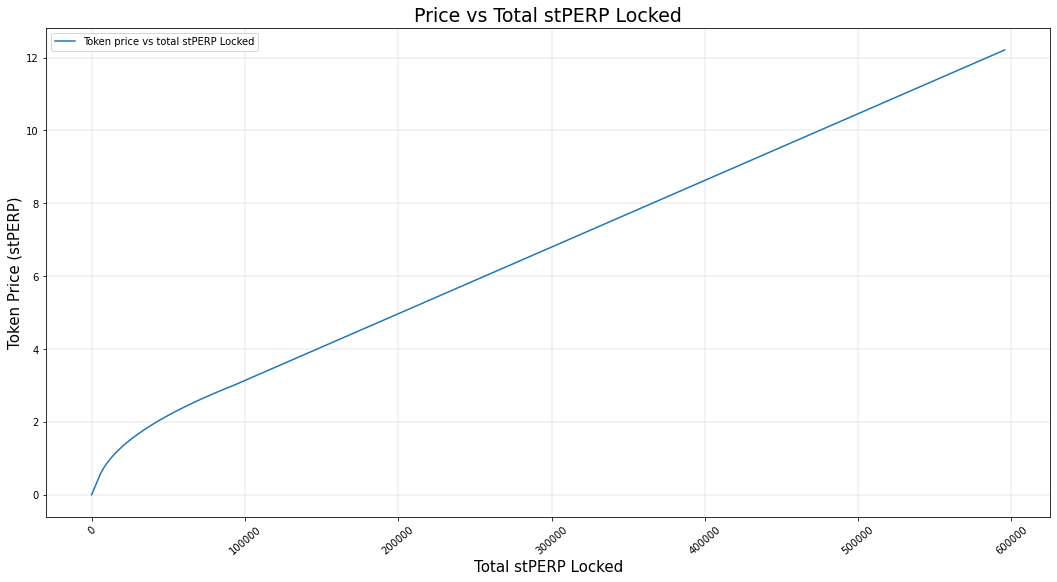

In [519]:
plt.figure(figsize=(18,9))
plt.xticks(rotation=40)
plt.grid(linewidth=0.3)
plt.plot(df.loc[:,'stPERP : Total Locked'],df.loc[:,'Token Price (stPERP)'],label='Token price vs total stPERP Locked')
plt.xlabel('Total stPERP Locked',fontsize = 15)
plt.ylabel('Token Price (stPERP)',fontsize = 15)
plt.title('Price vs Total stPERP Locked',fontsize = 19)
plt.legend()

plt.savefig('./stPERP/Price_vs_Total_stPERPLocked.png')

In [520]:
print('Final Token Price : ' + str(df.loc[len(df.index)-1,'Token Price (stPERP)']) + ' stPERP' )
print('Total stPERP Locked : ' + str(df.loc[len(df.index)-1,'stPERP : Total Locked']) + ' stPERP' )
print('Total Token Supply : ' + str(df.loc[len(df.index)-1,'Total Token Supply']) + '  tokens' )





Final Token Price : 12.211107537513657 stPERP
Total stPERP Locked : 595591.1702618082 stPERP
Total Token Supply : 136670.50806850553  tokens


In [ ]:
# df.tail(5)